In [1]:
# Readme


In [2]:
""" 
Code adapted from:
Title: Clustered Federated Learning: Model-Agnostic Distributed Multi-Task Optimization under Privacy Constraints
Author: Felix Sattler, Klaus-Robert Müller, Wojciech Samek
Date: 11.08.20
Code version: 23a1c38
Availability: https://github.com/felisat/clustered-federated-learning
"""


' \nCode adapted from:\nTitle: Clustered Federated Learning: Model-Agnostic Distributed Multi-Task Optimization under Privacy Constraints\nAuthor: Felix Sattler, Klaus-Robert Müller, Wojciech Samek\nDate: 11.08.20\nCode version: 23a1c38\nAvailability: https://github.com/felisat/clustered-federated-learning\n'

In [3]:
# Import helper
import os
import numpy as np
import coloredlogs, logging
from tqdm.auto import tqdm # Progress bar

# Import PyTorch packages 
import torch
import torchaudio
import torchaudio.transforms

# Import own functions
from utils.util import * # Helper functions
from utils.dataset import * # Dataset functions
from modules.server import Server # Server class
from modules.client import Client # Client class
from utils.logger import ExperimentLogger, display_train_stats, plot_cts # Logger classes and functions


In [4]:
config_file = './config/ConvAE3_SINS.yaml'


In [5]:

## Load config
config = import_config(config_file)

file_name = "log.txt"
file_name = os.path.join(config['logger']['logger-dir'], file_name)
os.makedirs(os.path.dirname(file_name), exist_ok=True)
logging.basicConfig(
    level=logging.DEBUG,
    handlers=[
        logging.FileHandler(file_name),
        logging.StreamHandler()
    ])
logger = logging.getLogger(__name__)
coloredlogs.install(level='INFO', logger=logger)

## Versions
logger.info('PyTorch version: ' + str(torch.__version__))
logger.info('Torchaudio  version: ' + str(torchaudio.__version__))
device = "cuda" if torch.cuda.is_available() else "cpu"
logger.info("PyTorch device: " + str(device))

config_path = "./config"


2021-05-12 22:09:00 rglitza-CSL __main__[14831] INFO PyTorch version: 1.6.0
2021-05-12 22:09:00 rglitza-CSL __main__[14831] INFO Torchaudio  version: 0.6.0a0+f17ae39
2021-05-12 22:09:00 rglitza-CSL __main__[14831] INFO PyTorch device: cuda


In [6]:
EPS_1 = 0
EPS_2 = 0
def condition(cfl_stat: ExperimentLogger, mean_norm: float, max_norm: float, matlab_data: dict, clusters: list, idx: int) -> bool:
    """Condition checking for bi-partitioning.

    Args:
        cfl_stat (ExperimentLogger): Clustered federated learning statistics object.
        mean_norm (float): Mean weight update norm.
        max_norm (float): Max weight update norm.
        matlab_data (dict): Data contining information about IR simulation.
        clusters (list of lists): Clusters with node ids.
        idx (int): Index of cluster in 'clusters' beeing checked.

    Returns:
        bool: Decision of performing bi-partitioning.
    """
    global EPS_1, EPS_2

    if hasattr(cfl_stat, 'rounds') == False:
        return False

    if cfl_stat.rounds[-1] == 1:
        EPS_1 = cfl_stat.mean_norm[0] + cfl_stat.max_norm[0] * 0.1
    
    EPS_2 = mean_norm + max_norm * 0.05

    for cluster in clusters:
        if len(cluster) < 2:
            return False

    if cfl_stat.rounds[-1] > MIN_ROUNDS:
        return ((mean_norm > EPS_1) & (mean_norm/max_norm < EPS_3))
    else:
        return False



In [7]:

# Set random seeds
torch.manual_seed(config['seeds']['random-seed'])
np.random.seed(config['seeds']['random-seed'])

# Get torch device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load MATLAB file containing RIR simulation information
matlab_data = loadmat(config['paths']['ir-meta-dir'])

# Set number of clients
if (config['client']['n_clientes'] != -1 and config['client']['n_clientes'] <= matlab_data['nrec'][0][0]):
    N_CLIENTS = int(config['client']['n_clientes'])
else:
    N_CLIENTS = matlab_data['nrec'][0][0]

global EPS_3, MIN_ROUNDS, NO_SPLIT_ROUNDS
EPS_3 = config['thresholds']['eps_3']
MIN_ROUNDS = config['thresholds']['min_rounds']
NO_SPLIT_ROUNDS = config['thresholds']['no_split_rounds']
COMMUNICATION_ROUNDS = int(config['client']['communication_rounds'])

## Split speakers
try:
    path = os.path.join(config['paths']['experiments-dir'], 'speakers_train.pkl')
    speakers_train = load_object(path)
    path = os.path.join(config['paths']['experiments-dir'], 'speakers_test.pkl')
    speakers_test = load_object(path)
    logging.info("Loaded speakers split-files.")
except:
    logging.warning("Speakers split-files not found. Performing speaker split.")
    speakers_train, speakers_test = split_speakers(config, ratio=config['server']['ratio'])

## Get combinations between speakers and sources
combinations = get_source_speaker(config=config, speakers=speakers_test)


2021-05-12 22:09:00 rglitza-CSL root[14831] INFO Loaded speakers split-files.


In [8]:

# Dataset for server containing clean speech from the LibriSpeech Database
server_data = LibriData(transforms=None, device=device, config=config, combinations=combinations, name="server", speakers=speakers_train)
server = Server(str_to_class(config['server']['network']), config['server']['optimizer'], server_data, config=config, writer=None)

clients = [
    Client(str_to_class(config['server']['network']),
    config['server']['optimizer'],
    NodeData(rec=rec, transforms=None, combinations=combinations, device=device, config=config, name="client"),
    idnum=rec,
    config=config,
    writer=None) 
    for rec in range(N_CLIENTS)]


2021-05-12 22:09:00 rglitza-CSL utils.dataset[14831] INFO Dataset uses 40 files
2021-05-12 22:09:02 rglitza-CSL modules.server[14831] INFO Loading checkpoint: ./experiments/AE3.pth
2021-05-12 22:09:02 rglitza-CSL modules.server[14831] INFO Loading checkpoint successful!
2021-05-12 22:09:02 rglitza-CSL utils.dataset[14831] INFO Dominant source of receiver 0 is A4
2021-05-12 22:09:02 rglitza-CSL modules.client[14831] INFO Dataset: Train 2 	 Eval 1
2021-05-12 22:09:02 rglitza-CSL utils.dataset[14831] INFO Dominant source of receiver 1 is A3
2021-05-12 22:09:03 rglitza-CSL modules.client[14831] INFO Dataset: Train 2 	 Eval 1
2021-05-12 22:09:03 rglitza-CSL utils.dataset[14831] INFO Dominant source of receiver 2 is A3
2021-05-12 22:09:03 rglitza-CSL modules.client[14831] INFO Dataset: Train 2 	 Eval 1
2021-05-12 22:09:03 rglitza-CSL utils.dataset[14831] INFO Dominant source of receiver 3 is A4
2021-05-12 22:09:03 rglitza-CSL modules.client[14831] INFO Dataset: Train 2 	 Eval 1
2021-05-12 22

In [9]:
if server.epoch < config['server']['epochs']:
    train_stats_server = server.compute_weight_update(epochs=(config['server']['epochs']-server.epoch))
else:
    train_stats_server = server.compute_weight_update(epochs=0)

## Init clusters
cluster_indices = [np.arange(len(clients)).astype("int")]
client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]
similarities = [1.0 for idcs in cluster_indices]

## Result logger
cfl_stats = ExperimentLogger()
cfl_stats.__name__ = "cfl_stats"

## Freeze and reset weights
server.reset_layer_zero()
for client in clients:
    client.synchronize(server)
    client.copy_old(server)
    client.freeze_layers()

# Threshold reached
clustered = False
not_split = -1


2021-05-12 22:09:15 rglitza-CSL modules.server[14831] INFO Resetting parameter device server: bottleneck1.weight
2021-05-12 22:09:15 rglitza-CSL modules.server[14831] INFO Resetting parameter device server: bottleneck1.bias


2021-05-12 22:09:52 rglitza-CSL utils.logger[14831] INFO Communication round: 1
2021-05-12 22:09:52 rglitza-CSL utils.logger[14831] INFO Mean/Max norm: 0.343283


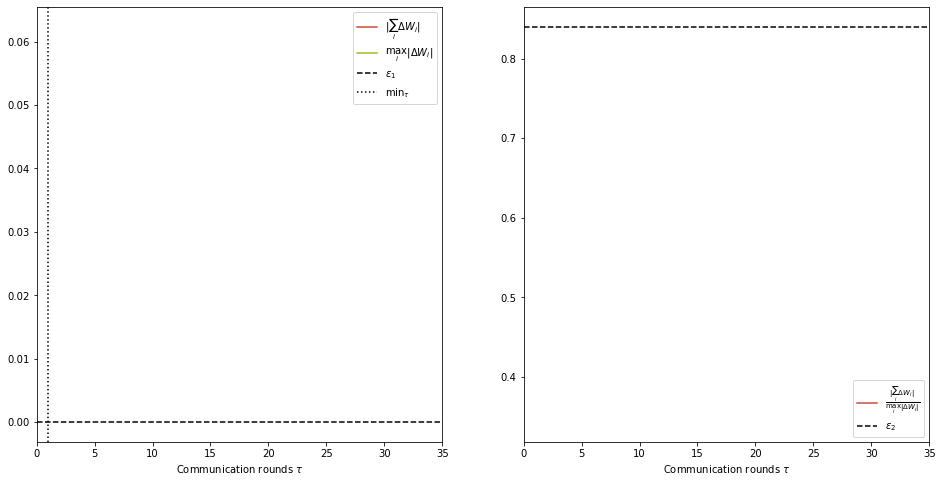

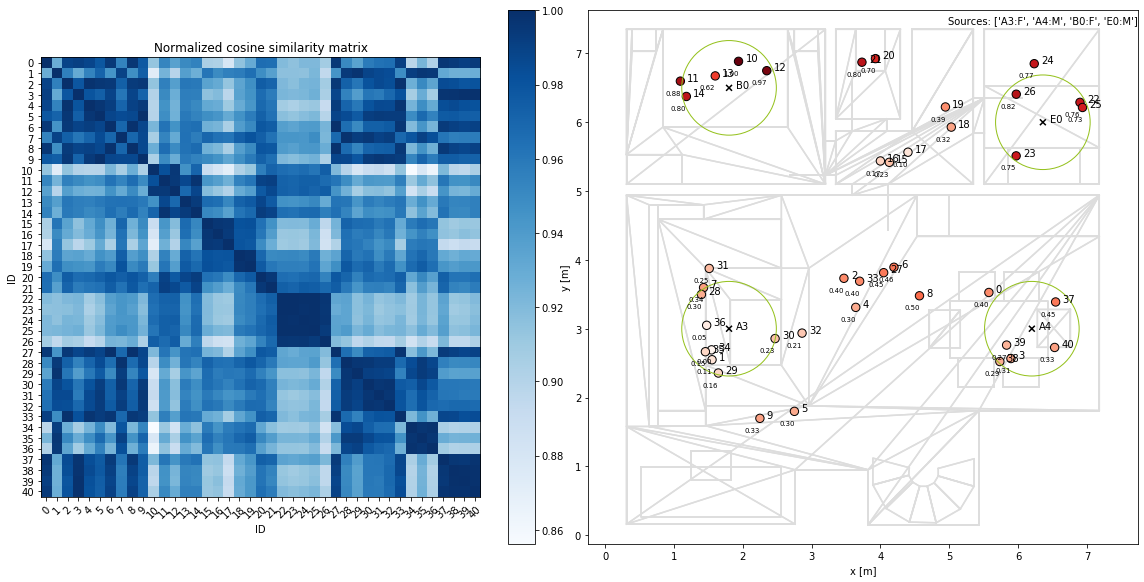

2021-05-12 22:10:33 rglitza-CSL utils.logger[14831] INFO Communication round: 2
2021-05-12 22:10:33 rglitza-CSL utils.logger[14831] INFO Mean/Max norm: 0.342013


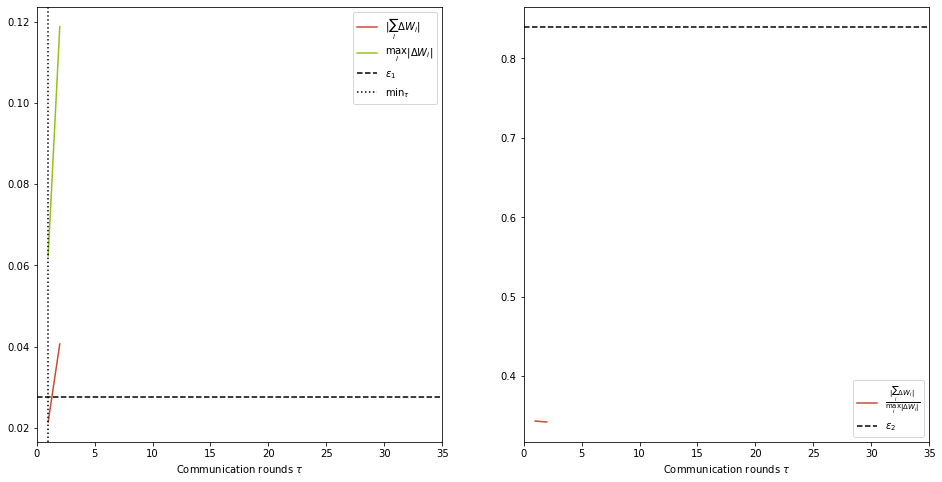

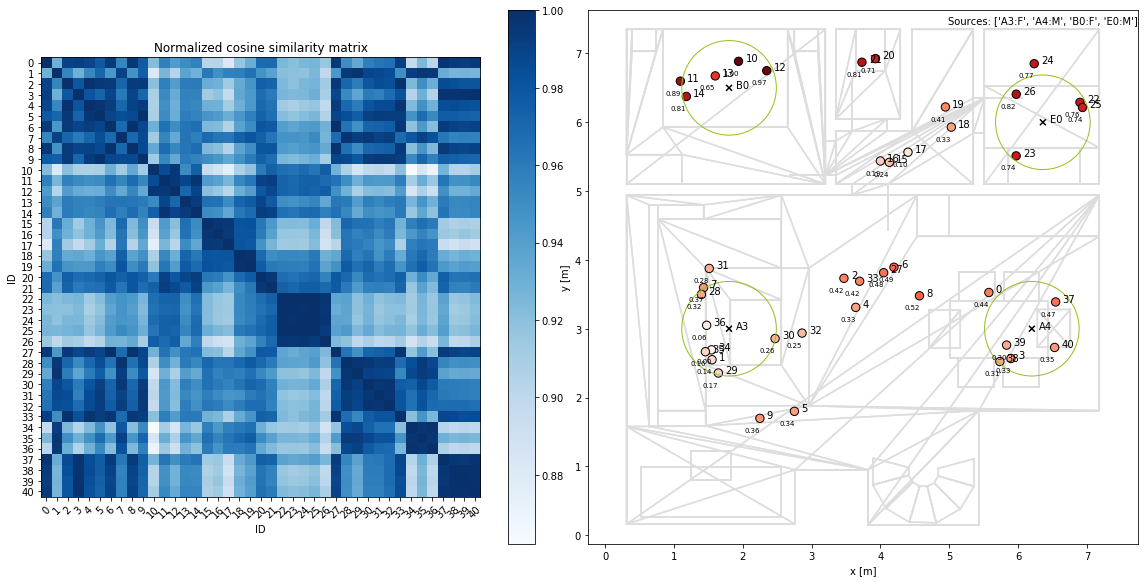

2021-05-12 22:11:13 rglitza-CSL utils.logger[14831] INFO Communication round: 3
2021-05-12 22:11:13 rglitza-CSL utils.logger[14831] INFO Mean/Max norm: 0.341229


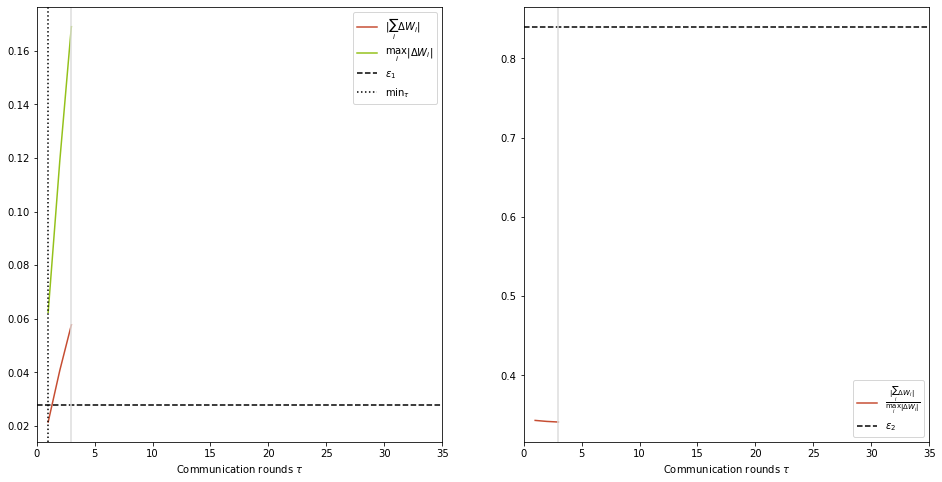

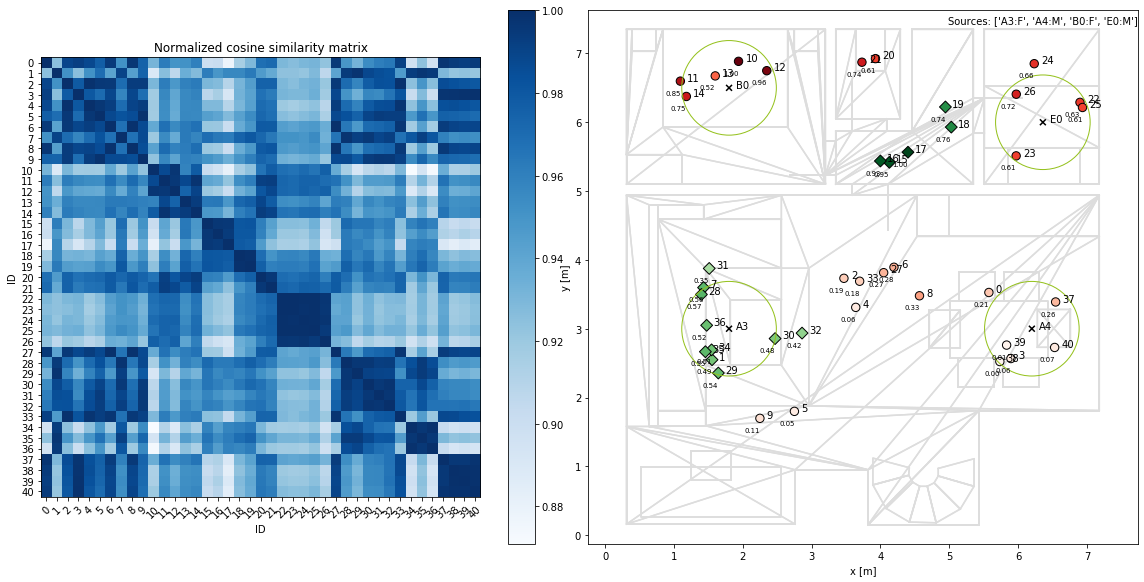

2021-05-12 22:11:54 rglitza-CSL utils.logger[14831] INFO Communication round: 4
2021-05-12 22:11:54 rglitza-CSL utils.logger[14831] INFO Mean/Max norm: 0.425092


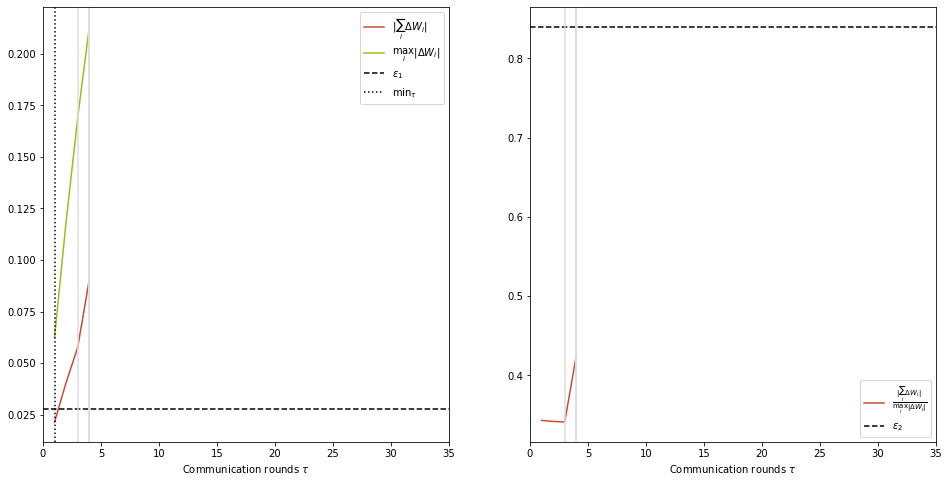

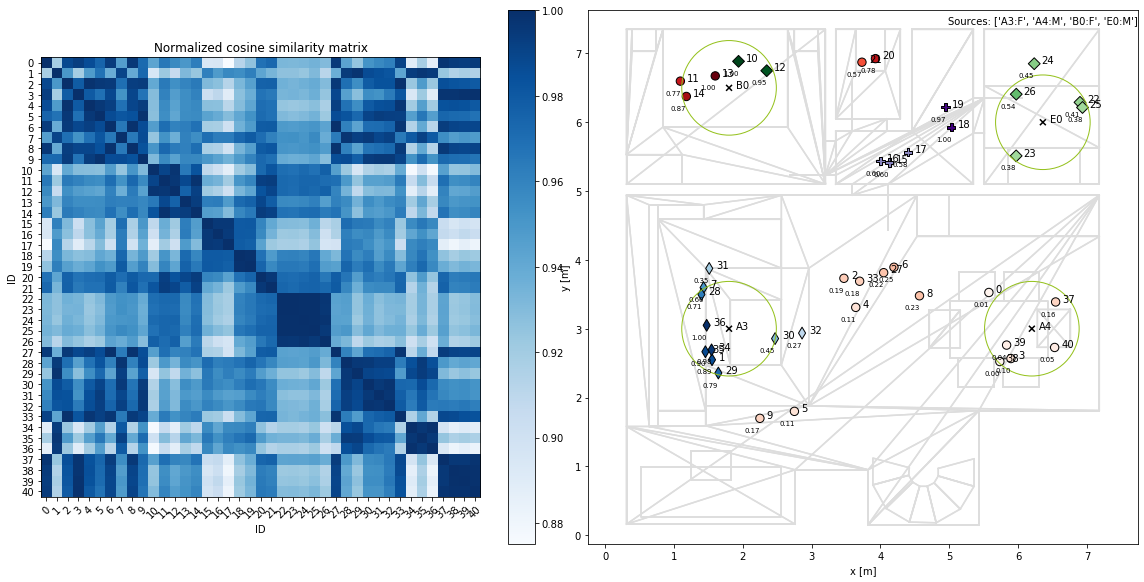

2021-05-12 22:12:35 rglitza-CSL utils.logger[14831] INFO Communication round: 5
2021-05-12 22:12:35 rglitza-CSL utils.logger[14831] INFO Mean/Max norm: 0.624198


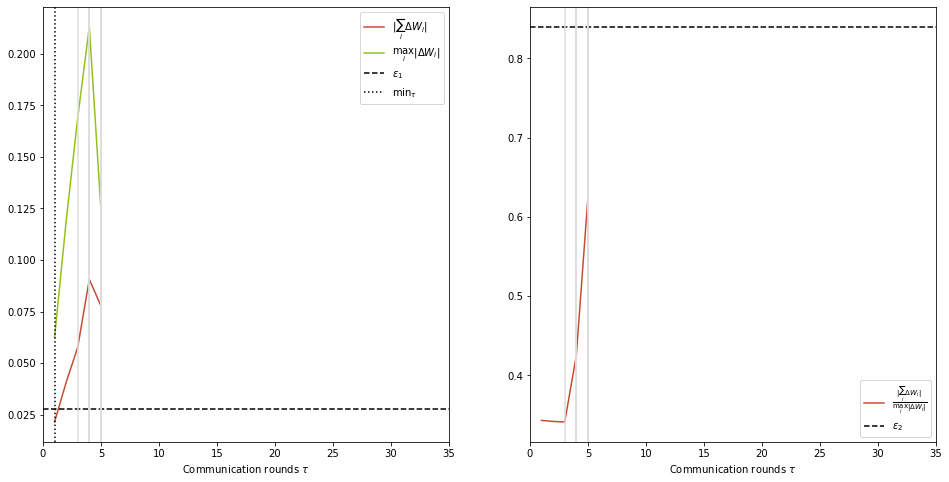

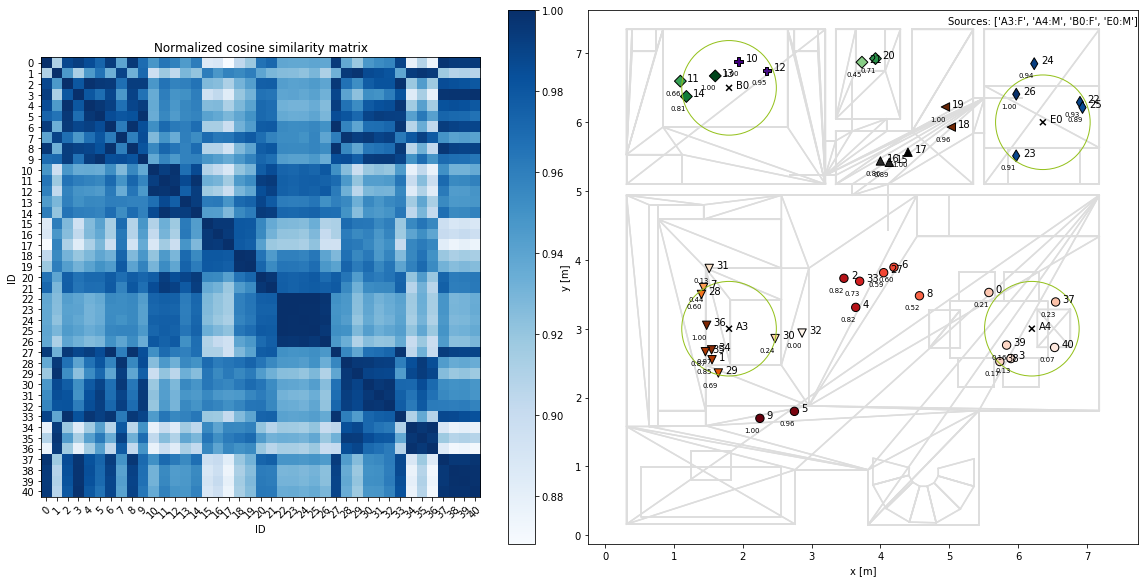

2021-05-12 22:13:16 rglitza-CSL utils.logger[14831] INFO Communication round: 6
2021-05-12 22:13:16 rglitza-CSL utils.logger[14831] INFO Mean/Max norm: 0.796553


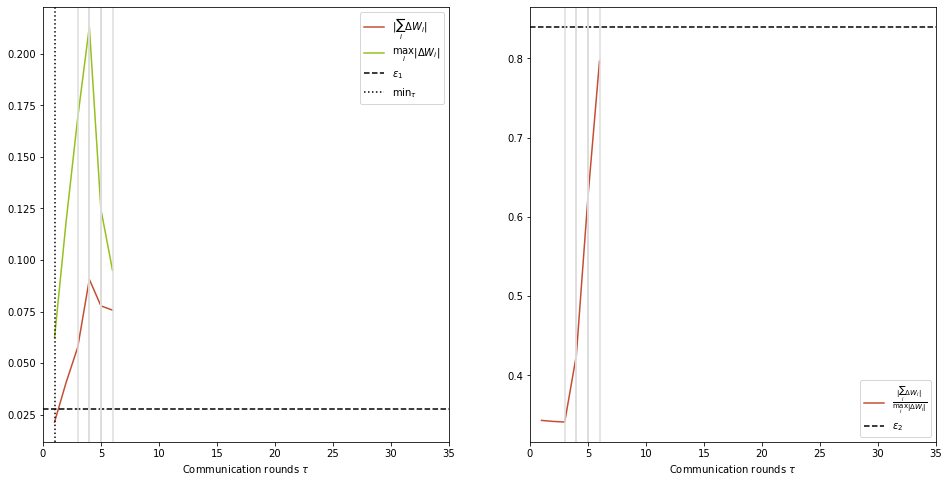

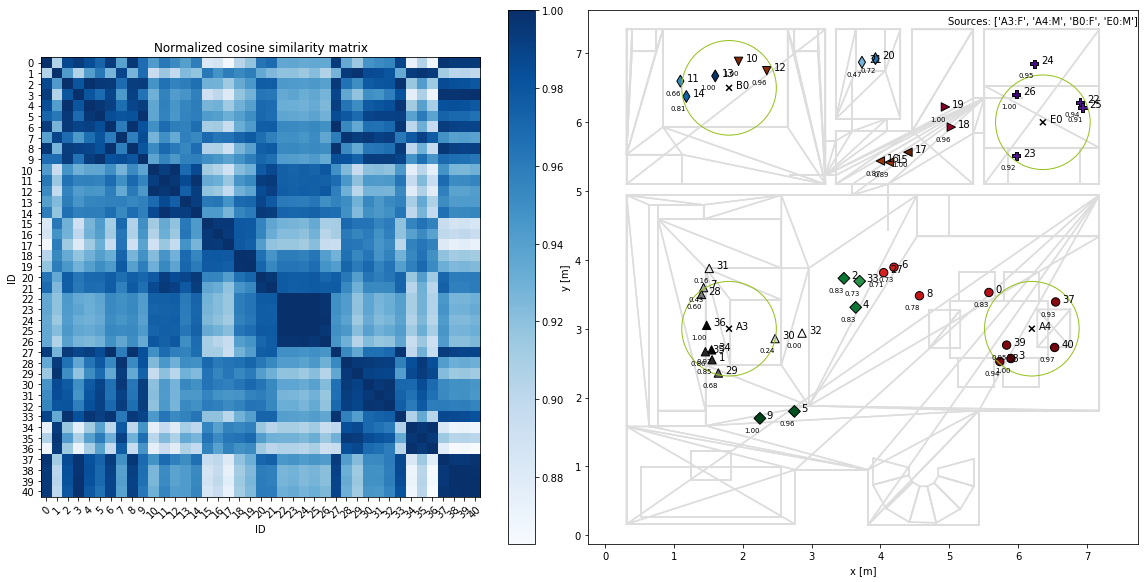

2021-05-12 22:13:57 rglitza-CSL utils.logger[14831] INFO Communication round: 7
2021-05-12 22:13:57 rglitza-CSL utils.logger[14831] INFO Mean/Max norm: 0.884221


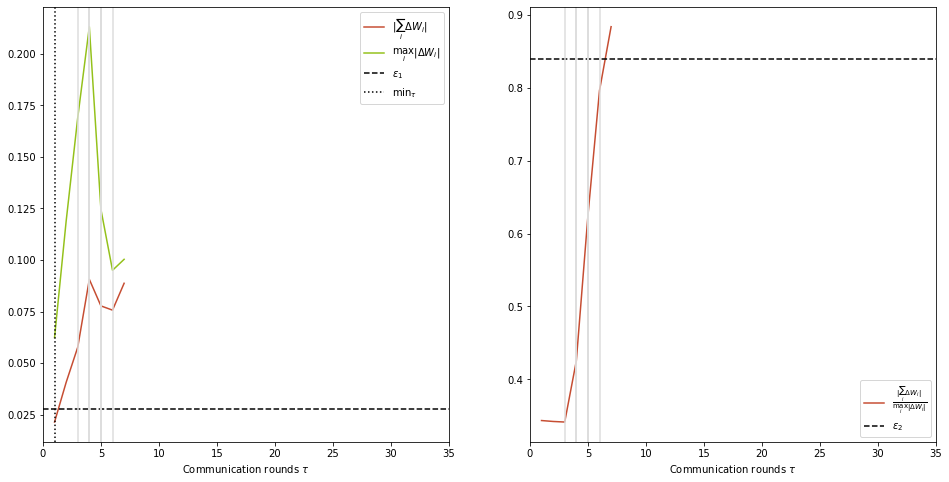

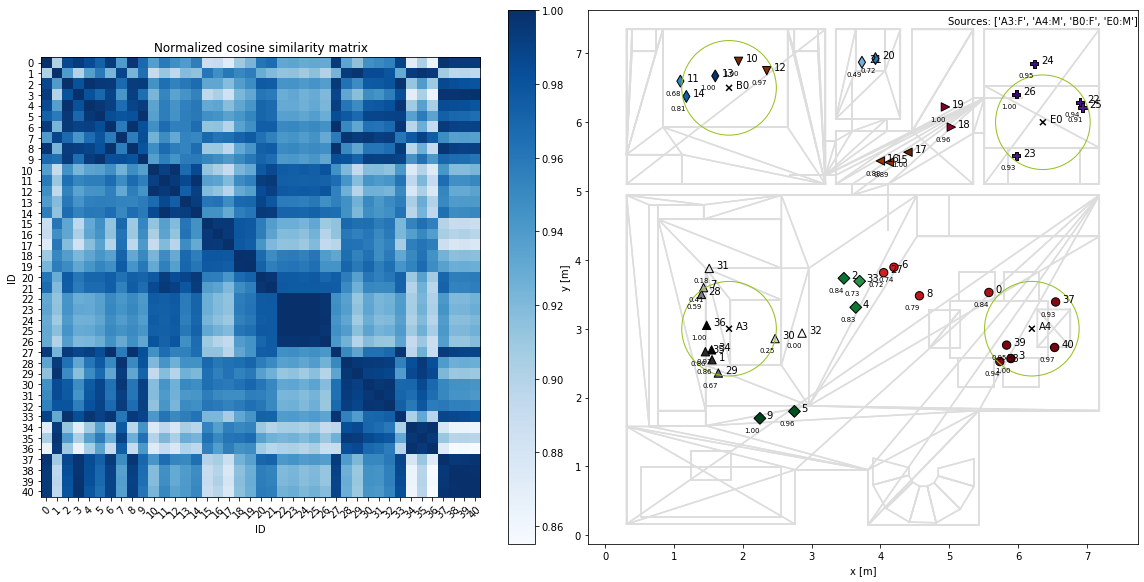

2021-05-12 22:14:38 rglitza-CSL utils.logger[14831] INFO Communication round: 8
2021-05-12 22:14:38 rglitza-CSL utils.logger[14831] INFO Mean/Max norm: 0.885950


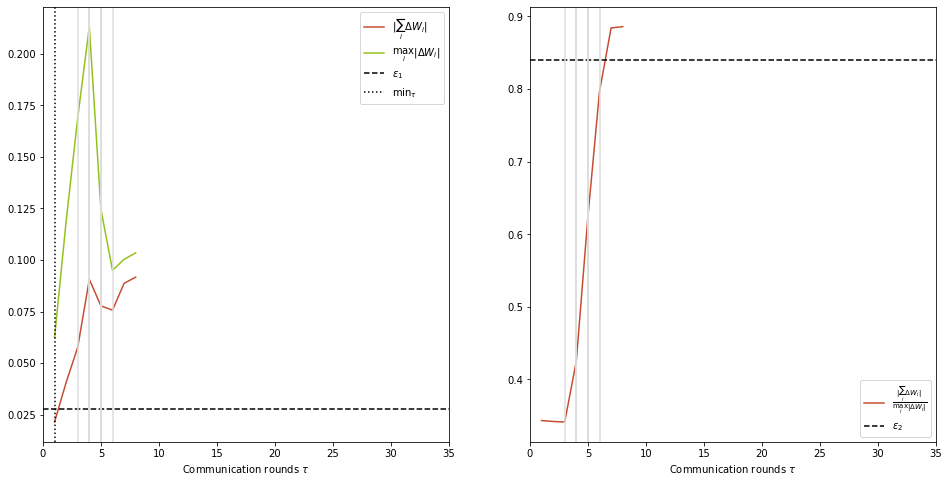

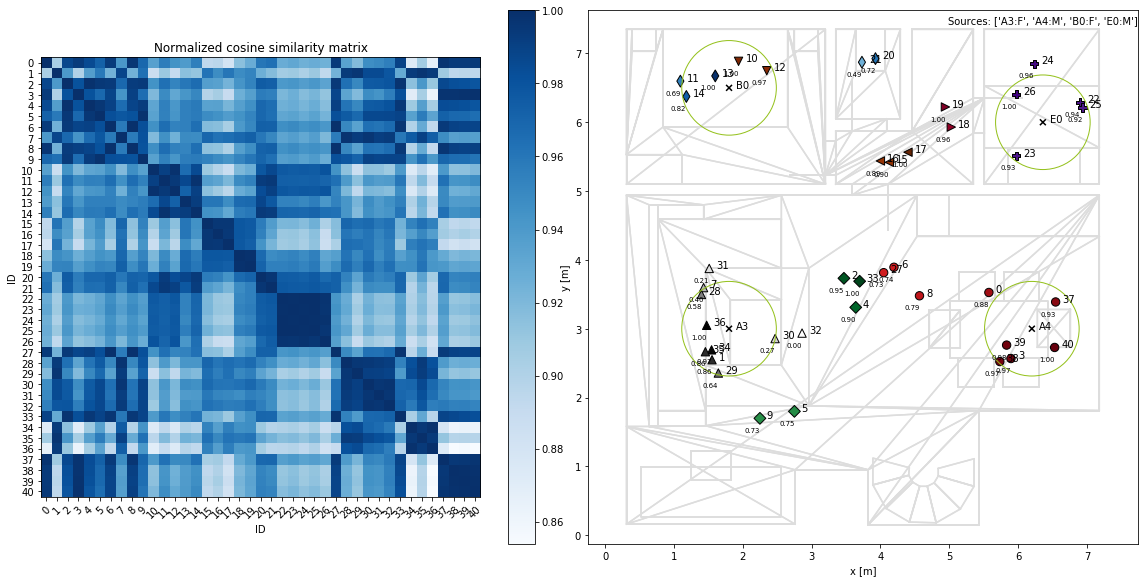

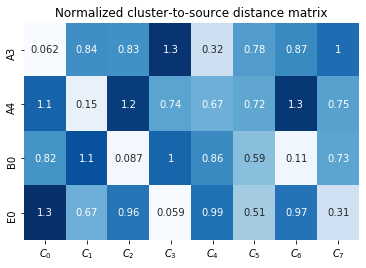

In [10]:
for c_round in tqdm(range(1, COMMUNICATION_ROUNDS+1), desc="Communication round"):
    logger.debug("\n")
    logger.debug('-------------------------------------------------------------------')
    logger.debug('Communication round %d/%d' % (c_round, COMMUNICATION_ROUNDS))

    # Restore weight of precious round for aggregation
    for client in clients:
        client.reset()

    # Synchronize cluster weights
    server.aggregate_clusterwise(client_clusters)
    for client in clients:
        client.synchronize()

    participating_clients = server.select_clients(clients, frac=1.0)

    desc = "Client"
    tk0 = tqdm(participating_clients, leave=False, total=len(participating_clients), desc=desc)
    # Train all clients on their local data
    for i, client in enumerate(tk0):
        train_stats = client.compute_weight_update(epochs=config['client']['epochs'])
        tk0.set_postfix(loss=(train_stats))

    similarities = server.compute_pairwise_similarities(clients)

    clustered = False
    cluster_indices_tmp = []
    max_norms = []
    mean_norms = []
    for idx, idc in enumerate(cluster_indices):
        max_norm = server.compute_max_update_norm([clients[i] for i in idc])
        mean_norm = server.compute_mean_update_norm([clients[i] for i in idc])
        max_norms.append(max_norm)
        mean_norms.append(mean_norm)

        # Perform bi-partitioning, if number of clients in cluster > 2
        if len(idc) >= 2:
            new_idc = server.agglomerative_clustering(similarities[idc][:,idc], idc)
        else:
            new_idc = [idc]
        
        # Check if bi-partitioning needs to be performed
        if condition(cfl_stats, mean_norm, max_norm, matlab_data, new_idc, idx) or ((c_round == COMMUNICATION_ROUNDS) & (not_split == -1)):   
            # Add split to log object
            cfl_stats.log({"split" : c_round})
            # Set clustered true
            clustered = True

            # Add c_1 and c_2 to C'
            cluster_indices_tmp += new_idc
            client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]

            not_split = 0
        else:
            # If threshold now reached, add c to C'
            cluster_indices_tmp += [idc]

    # Evaluate client performance
    loss_clients = []
    tk1 = tqdm(clients, leave=False, total=len(clients), desc="Client")
    for i, client in enumerate(tk1):
        eval_stats = client.evaluate()
        loss_clients.append(eval_stats['hparam/loss'])

    # Write back temporary cluster C' in C
    cluster_indices = cluster_indices_tmp

    # Check if clustering wasn't performed for 3 round in a row
    if clustered == False:
        not_split = -1 if not_split == -1 else not_split + 1
    if not_split > NO_SPLIT_ROUNDS:
        break

    # Calculate membership values
    if 'mv_weight' in config['thresholds']:
        weight = config['thresholds']['mv_weight']
    else:
        weight = 0.5
    memberships, _, _ = get_memberships(cluster_indices, similarities, weight=weight)
    
    # Log all data
    cfl_stats.log({
                "loss_clients" : loss_clients, "mean_norm" : mean_norms[0], "max_norm" : max_norms[0],
                "mean_norms" : mean_norms, "max_norms" : max_norms,
                "rounds" : c_round,
                "clusters" : cluster_indices, "similarities" : similarities,
                "mvs" : memberships,
                "combinations" : combinations,
                "server_loss" : train_stats_server,
                'combinations' : combinations
            })
    
    # Display the train stats for each round
    display_train_stats(cfl_stats, config, EPS_1, EPS_2, EPS_3, COMMUNICATION_ROUNDS)

    logger.debug('-------------------------------------------------------------------')
    logger.debug("\n")

# Calculate and plot normalized cluster-to-source distance
cts_d = normalized_cluster_to_source_distance(cfl_stats.clusters[-1], clients, cfl_stats.mvs[-1], config)
plot_cts(cts_d, config)